In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
!pip install albumentations --quiet
!pip install scikit-image --quiet

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from skimage.measure import label, regionprops

2025-06-24 16:33:54.937167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750782835.176490      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750782835.242379      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMAGE_SIZE = 256
NUM_CLASSES = 7  # background, building, vegetation, water, road, vehicle, flooded_area
DISASTER_CLASSES = ['flood', 'fire', 'landslide']
BATCH_SIZE = 4
EPOCHS = 25

In [4]:
def build_disaster_classifier():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.ReLU()(x)
    return x

In [6]:
def build_unet():
    inputs = tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    c1 = conv_block(inputs, 64)
    p1 = tf.keras.layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 128)
    p2 = tf.keras.layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 256)
    p3 = tf.keras.layers.MaxPooling2D()(c3)
    b = conv_block(p3, 512)
    u1 = tf.keras.layers.UpSampling2D()(b)
    u1 = tf.keras.layers.Concatenate()([u1, c3])
    c4 = conv_block(u1, 256)
    u2 = tf.keras.layers.UpSampling2D()(c4)
    u2 = tf.keras.layers.Concatenate()([u2, c2])
    c5 = conv_block(u2, 128)
    u3 = tf.keras.layers.UpSampling2D()(c5)
    u3 = tf.keras.layers.Concatenate()([u3, c1])
    c6 = conv_block(u3, 64)
    outputs = tf.keras.layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(c6)
    return tf.keras.Model(inputs, outputs)

In [7]:
def preprocess(image_path, mask_path):
    img = Image.open(image_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = Image.open(mask_path).resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.NEAREST)
    return np.array(img)/255.0, np.array(mask)

In [8]:
def load_dataset(img_dir, mask_dir):
    data = []
    for fname in os.listdir(img_dir):
        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname)
        if os.path.exists(mask_path):
            img, mask = preprocess(img_path, mask_path)
            data.append((img, mask))
    return data

In [9]:
def count_objects(mask, class_id):
    labeled = label(mask == class_id)
    return len(regionprops(labeled))

In [10]:
def visualize_prediction(model, x, y, index=0):
    pred = model.predict(np.expand_dims(x[index], axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)
    true_mask = np.argmax(y[index], axis=-1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x[index])
    axs[0].set_title("Input Image")

    axs[1].imshow(true_mask, cmap="tab20")
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred_mask, cmap="tab20")
    axs[2].set_title("Prediction")
    plt.show()

    print(f"Buildings: {count_objects(pred_mask, 1)}")
    print(f"Vegetation: {count_objects(pred_mask, 2)}")
    print(f"Water: {count_objects(pred_mask, 3)}")
    print(f"Roads: {count_objects(pred_mask, 4)}")
    print(f"Vehicles: {count_objects(pred_mask, 5)}")



In [11]:
# ✅ Load flood data (has masks)
flood_data = load_dataset(
    "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image",
    "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask"
)
flood_labels = [0] * len(flood_data)

# ✅ Load fire images (no masks, so skip segmentation)
def load_fire_images(img_dir):
    images = []
    for fname in os.listdir(img_dir):
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
        images.append(np.array(img) / 255.0)
    return images

fire_images = load_fire_images("/kaggle/input/fire-dataset/fire_dataset/fire_images")
fire_labels = [1] * len(fire_images)

# ✅ Load landslide data (has masks)
landslide_data = load_dataset(
    "/kaggle/input/landslide-divided/dataset/train/images",
    "/kaggle/input/landslide-divided/dataset/train/masks"
)
landslide_labels = [2] * len(landslide_data)


In [12]:
# For classification, combine all images and labels
flood_images = [x[0] for x in flood_data]
landslide_images = [x[0] for x in landslide_data]

all_images = flood_images + fire_images + landslide_images
all_labels = flood_labels + fire_labels + landslide_labels


In [13]:
X = np.array(all_images)
y_class = np.array(all_labels)

In [31]:
import os

print("Flood sample:", os.listdir("/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image")[:5])
print("Landslide sample:", os.listdir("/kaggle/input/landslide-divided/dataset/train/images")[:5])


Flood sample: ['8379.jpg', '7405.jpg', '10166.jpg', '6615.jpg', '7331.jpg']
Landslide sample: ['image_281.png', 'image_418.png', 'image_3312.png', 'image_3510.png', 'image_2231.png']


In [14]:
from PIL import Image
import os
import numpy as np

def load_images_only(img_dir):
    images = []
    for fname in os.listdir(img_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(img_dir, fname)
            img = Image.open(path).convert('RGB').resize((256, 256))
            images.append(np.array(img) / 255.0)
    return images


In [15]:
# Reload fire images (already loaded before, skip if done)
fire_images = load_images_only("/kaggle/input/fire-dataset/fire_dataset/fire_images")

# ✅ Load flood images without expecting masks
flood_images = load_images_only("/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image")

# ✅ Load landslide images
landslide_images = load_images_only("/kaggle/input/landslide-divided/dataset/train/images")

# ✅ Assign class labels
flood_labels = [0] * len(flood_images)
fire_labels = [1] * len(fire_images)
landslide_labels = [2] * len(landslide_images)


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

X = np.array(flood_images + fire_images + landslide_images)
y_class = np.array(flood_labels + fire_labels + landslide_labels)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss.split(X, y_class):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_class[train_idx], y_class[val_idx]


In [22]:
clf_model = build_disaster_classifier()

clf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=4
)

Epoch 1/4
55/55 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7452 - loss: 0.8785 - val_accuracy: 0.9043 - val_loss: 0.4457
Epoch 2/4
55/55 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9069 - loss: 0.4006 - val_accuracy: 0.9453 - val_loss: 0.2302
Epoch 3/4
55/55 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9507 - loss: 0.1936 - val_accuracy: 0.9567 - val_loss: 0.1681
Epoch 4/4
55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9566 - loss: 0.1385 - val_accuracy: 0.9567 - val_loss: 0.1264


In [23]:
DISASTER_CLASSES = ['flood', 'fire', 'landslide']

In [24]:
# DISASTER_CLASSES = ['flood', 'fire', 'landslide']

# Find indices for each class in y_val
flood_indices = [i for i, label in enumerate(y_val) if label == 0]
fire_indices = [i for i, label in enumerate(y_val) if label == 1]
landslide_indices = [i for i, label in enumerate(y_val) if label == 2]

print("Flood:", flood_indices[:3])
print("Fire:", fire_indices[:3])
print("Landslide:", landslide_indices[:3])


Flood: [71, 213, 260]
Fire: [0, 1, 2]
Landslide: [6, 7, 8]


In [39]:
import os

print("Flood sample:", os.listdir("/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image")[:5])
print("Landslide sample:", os.listdir("/kaggle/input/landslide-divided/dataset/train/images")[:5])


Flood sample: ['8379.jpg', '7405.jpg', '10166.jpg', '6615.jpg', '7331.jpg']
Landslide sample: ['image_281.png', 'image_418.png', 'image_3312.png', 'image_3510.png', 'image_2231.png']


In [25]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

DISASTER_CLASSES = ['flood', 'fire', 'landslide']

# Define your dataset root paths
dataset_paths = {
    'flood': "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image",
    'fire': "/kaggle/input/fire-dataset/fire_dataset/fire_images",
    'landslide': "/kaggle/input/landslide-divided/dataset/train/images"
}

def classify_by_filename(filename):
    found = False
    for disaster_type, path in dataset_paths.items():
        file_path = os.path.join(path, filename)
        if os.path.exists(file_path):
            found = True
            img = Image.open(file_path).convert('RGB').resize((256, 256))
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = clf_model.predict(img_array)
            pred_class = np.argmax(pred[0])

            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Predicted: {DISASTER_CLASSES[pred_class]} | From: {disaster_type}")
            plt.show()
            break

    if not found:
        print(f"❌ File '{filename}' not found in any dataset folder.")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


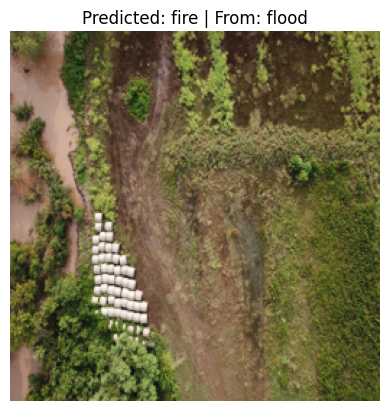

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


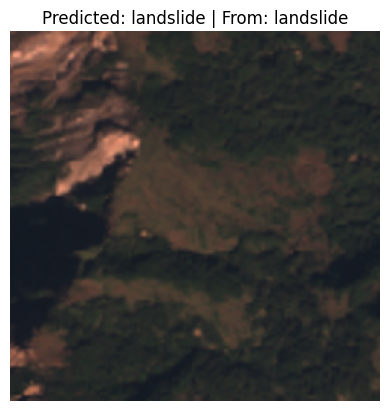

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


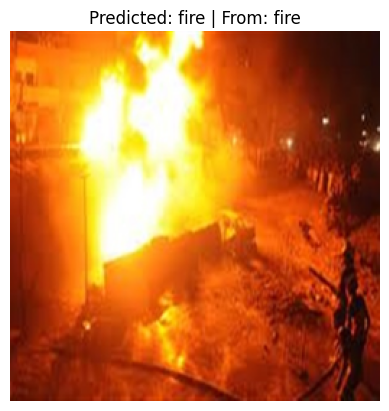

In [26]:
classify_by_filename("8379.jpg")  # Should classify from flood folder
classify_by_filename("image_281.png")  # Should classify from landslide folder
classify_by_filename("fire.100.png")  # From fire folder


In [27]:
clf_model.save("disaster_classifier.h5")

In [28]:
from kaggle_secrets import UserSecretsClient
from IPython.display import FileLink
FileLink('disaster_classifier.h5')


/kaggle/working/disaster_classifier.h5

In [29]:

from IPython.display import FileLink
FileLink('disaster_classifier.h5')


/kaggle/working/disaster_classifier.h5

In [31]:
import os 
size_bytes = os.path.getsize("disaster_classifier.h5")
print(f"Model size: {size_bytes / (1024**2):.2f} MB")


Model size: 0.26 MB


In [38]:
from PIL import Image
import numpy as np
import os

def load_dataset_with_matching_ids(image_dir, mask_dir, img_prefix="", img_suffix="", mask_prefix="", mask_suffix="", extension_match=True):
    dataset = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))]

    def extract_id(filename):
        return ''.join(filter(str.isdigit, filename))  # Extract numbers from filename

    image_id_map = {extract_id(f): f for f in image_files}
    mask_id_map = {extract_id(f): f for f in mask_files}

    common_ids = set(image_id_map.keys()) & set(mask_id_map.keys())

    for id in sorted(common_ids):
        img_path = os.path.join(image_dir, image_id_map[id])
        mask_path = os.path.join(mask_dir, mask_id_map[id])

        img = Image.open(img_path).convert('RGB').resize((256, 256))
        mask = Image.open(mask_path).resize((256, 256), resample=Image.NEAREST)

        dataset.append((np.array(img) / 255.0, np.array(mask)))

    print(f"✅ Loaded {len(dataset)} image–mask pairs from {image_dir}")
    return dataset


In [39]:
flood_seg_data = load_dataset(
    "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image",
    "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask"
)

landslide_seg_data = load_dataset(
    "/kaggle/input/landslide-divided/dataset/train/images",
    "/kaggle/input/landslide-divided/dataset/train/masks"
)


In [40]:
landslide_images = os.listdir("/kaggle/input/landslide-divided/dataset/train/images")
landslide_masks  = os.listdir("/kaggle/input/landslide-divided/dataset/train/masks")

print("Landslide image example:", landslide_images[:5])
print("Landslide mask example:", landslide_masks[:5])


Landslide image example: ['image_281.png', 'image_418.png', 'image_3312.png', 'image_3510.png', 'image_2231.png']
Landslide mask example: ['mask_3419.png', 'mask_953.png', 'mask_377.png', 'mask_1445.png', 'mask_1642.png']


In [41]:
import os

flood_imgs = sorted(os.listdir("/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image"))[:10]
flood_masks = sorted(os.listdir("/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask"))[:10]

print("Flood Image Files:", flood_imgs)
print("Flood Mask Files:", flood_masks)


Flood Image Files: ['10165.jpg', '10166.jpg', '6279.jpg', '6614.jpg', '6615.jpg', '6618.jpg', '6703.jpg', '6704.jpg', '6706.jpg', '6707.jpg']
Flood Mask Files: ['10165_lab.png', '10166_lab.png', '6279_lab.png', '6614_lab.png', '6615_lab.png', '6618_lab.png', '6703_lab.png', '6704_lab.png', '6706_lab.png', '6707_lab.png']


In [42]:
def extract_id(filename):
    return ''.join(filter(str.isdigit, filename))

print("Flood Image IDs:", [extract_id(f) for f in flood_imgs])
print("Flood Mask IDs:", [extract_id(f) for f in flood_masks])


Flood Image IDs: ['10165', '10166', '6279', '6614', '6615', '6618', '6703', '6704', '6706', '6707']
Flood Mask IDs: ['10165', '10166', '6279', '6614', '6615', '6618', '6703', '6704', '6706', '6707']


In [43]:
import os
from PIL import Image
import numpy as np

# Try just 5 files
image_dir = "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image"
mask_dir = "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask"

image_files = sorted(os.listdir(image_dir))[:5]
mask_files = sorted(os.listdir(mask_dir))[:5]

print("Sample image files:", image_files)
print("Sample mask files:", mask_files)

for img_name, mask_name in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, mask_name)
    print(f"Opening: {img_path} and {mask_path}")

    img = Image.open(img_path).convert('RGB').resize((256, 256))
    mask = Image.open(mask_path).convert('L').resize((256, 256), resample=Image.NEAREST)
    
    print(f"✅ Image shape: {np.array(img).shape}, Mask shape: {np.array(mask).shape}")


Sample image files: ['10165.jpg', '10166.jpg', '6279.jpg', '6614.jpg', '6615.jpg']
Sample mask files: ['10165_lab.png', '10166_lab.png', '6279_lab.png', '6614_lab.png', '6615_lab.png']
Opening: /kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image/10165.jpg and /kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask/10165_lab.png
✅ Image shape: (256, 256, 3), Mask shape: (256, 256)
Opening: /kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image/10166.jpg and /kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask/10166_lab.png
✅ Image shape: (256, 256, 3), Mask shape: (256, 256)
Opening: /kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image/6279.jpg and /kaggle/input/aerial-imagery-dataset-floodnet-chal

In [44]:
flood_seg_data = load_dataset_with_matching_ids(
    "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image",
    "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask"
)


✅ Loaded 51 image–mask pairs from /kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image


In [45]:
# Unpack the flood segmentation dataset
X_seg, Y_seg = zip(*flood_seg_data)

# Convert to numpy arrays
X_seg = np.array(X_seg)  # Shape: (N, 256, 256, 3)
Y_seg = np.array(Y_seg)  # Shape: (N, 256, 256)

# Clip mask values to valid class range (0 to NUM_CLASSES - 1)
Y_seg = np.clip(Y_seg, 0, NUM_CLASSES - 1)

# Optional: Check which class IDs are present
print("✅ Unique class IDs in masks after clipping:", np.unique(Y_seg))

# Convert masks to one-hot format (for softmax output)
Y_seg = tf.keras.utils.to_categorical(Y_seg, num_classes=NUM_CLASSES)  # Shape: (N, 256, 256, NUM_CLASSES)


✅ Unique class IDs in masks after clipping: [0 1 2 3 4 5 6]


In [ ]:
print("h")

In [ ]:
# Build and compile the model
seg_model = build_unet()
seg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_seg_train, X_seg_val, Y_seg_train, Y_seg_val = train_test_split(X_seg, Y_seg, test_size=0.2, random_state=42)

# Train the U-Net model
seg_model.fit(X_seg_train, Y_seg_train, validation_data=(X_seg_val, Y_seg_val), epochs=12, batch_size=4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


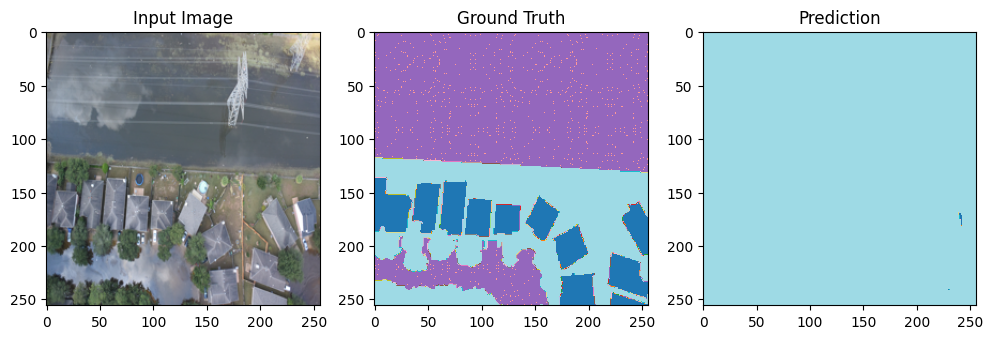

Buildings: 2
Vegetation: 0
Water: 0
Roads: 0
Vehicles: 0


In [67]:
visualize_prediction(seg_model, X_seg_val, Y_seg_val, index=0)


In [ ]:
seg_model.save("unet_model.h5")

In [ ]:
!pip install tf2onnx
!python -m tf2onnx.convert --saved-model ./model_dir --output model.onnx


In [ ]:
# Load landslide segmentation data using same function
landslide_seg_data = load_dataset_with_matching_ids(
    "/kaggle/input/landslide-divided/dataset/train/images",
    "/kaggle/input/landslide-divided/dataset/train/masks"
)

# Prepare data
X_land, Y_land = zip(*landslide_seg_data)
X_land = np.array(X_land)
Y_land = np.clip(np.array(Y_land), 0, NUM_CLASSES - 1)  # Clip to valid class range

# One-hot encode masks
Y_land = tf.keras.utils.to_categorical(Y_land, num_classes=NUM_CLASSES)

# Train-validation split
X_land_train, X_land_val, Y_land_train, Y_land_val = train_test_split(
    X_land, Y_land, test_size=0.2, random_state=42
)

# Build and train U-Net model
landslide_model = build_unet()
landslide_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

landslide_model.fit(
    X_land_train, Y_land_train,
    validation_data=(X_land_val, Y_land_val),
    epochs=18,
    batch_size=4
)

# Visualize prediction
visualize_prediction(landslide_model, X_land_val, Y_land_val, index=0)


In [ ]:
fire_seg_data = load_dataset_with_matching_ids(
    "/kaggle/input/fire-segmentation-dataset/images",
    "/kaggle/input/fire-segmentation-dataset/masks"
)

X_fire, Y_fire = zip(*fire_seg_data)
X_fire = np.array(X_fire)
Y_fire = np.clip(np.array(Y_fire), 0, NUM_CLASSES - 1)
Y_fire = tf.keras.utils.to_categorical(Y_fire, num_classes=NUM_CLASSES)

X_fire_train, X_fire_val, Y_fire_train, Y_fire_val = train_test_split(
    X_fire, Y_fire, test_size=0.2, random_state=42
)

fire_model = build_unet()
fire_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

fire_model.fit(
    X_fire_train, Y_fire_train,
    validation_data=(X_fire_val, Y_fire_val),
    epochs=18,
    batch_size=4
)

visualize_prediction(fire_model, X_fire_val, Y_fire_val, index=0)


In [ ]:
# Save flood segmentation model
seg_model.save("flood_unet_model.h5")

# Save landslide segmentation model
landslide_model.save("landslide_unet_model.h5")


In [ ]:
# Flood model to ONNX
!python -m tf2onnx.convert --keras flood_unet_model.h5 --output flood_unet_model.onnx

# Landslide model to ONNX
!python -m tf2onnx.convert --keras landslide_unet_model.h5 --output landslide_unet_model.onnx


In [ ]:
import onnxruntime as ort
from PIL import Image
import numpy as np

CLASS_LABELS = ['Background', 'Buildings', 'Vegetation', 'Water', 'Roads', 'Vehicles', 'Flooded Area']  # Update as needed

# Load ONNX model
flood_sess = ort.InferenceSession("flood_unet_model.onnx")
landslide_sess = ort.InferenceSession("landslide_unet_model.onnx")

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB').resize((256, 256))
    img_np = np.array(image).astype(np.float32) / 255.0
    img_np = np.expand_dims(img_np, axis=0)  # (1, 256, 256, 3)
    return img_np, image

def get_prediction(session, image_path):
    input_name = session.get_inputs()[0].name
    img_np, original = preprocess_image(image_path)

    pred = session.run(None, {input_name: img_np})[0]  # (1, 256, 256, NUM_CLASSES)
    pred_mask = np.argmax(pred[0], axis=-1)  # (256, 256)

    # Count pixels per class
    unique, counts = np.unique(pred_mask, return_counts=True)
    pixel_counts = dict(zip(unique, counts))

    # Print readable class counts
    print(f"Prediction for {os.path.basename(image_path)}:")
    for cls_id, count in pixel_counts.items():
        if cls_id < len(CLASS_LABELS):
            print(f" - {CLASS_LABELS[cls_id]}: {count} pixels")

    # Optionally show the prediction mask
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="tab20")
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()
